In [20]:
import pandas as pd
import matplotlib.pyplot as plt  
import seaborn as sns     
import numpy as np
import re
from collections import Counter
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import ast
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from IPython.display import display
import warnings
warnings.filterwarnings("ignore")

In [21]:
df = pd.read_csv("ready_for_analysis.csv")

In [22]:
ham_total = df[df['label'] == 0].shape[0]
spam_total = df[df['label'] == 1].shape[0]

ham_forwarded = df[(df['label'] == 0) & (df['is_forwarded'] == 1)].shape[0]
spam_forwarded = df[(df['label'] == 1) & (df['is_forwarded'] == 1)].shape[0]

ham_forwarded_pct = round((ham_forwarded / ham_total) * 100, 2)
spam_forwarded_pct = round((spam_forwarded / spam_total) * 100, 2)

print(f"Ham forwarded: {ham_forwarded} / {ham_total} ({ham_forwarded_pct}%)")
print(f"Spam forwarded: {spam_forwarded} / {spam_total} ({spam_forwarded_pct}%)")

Ham forwarded: 2636 / 16545 (15.93%)
Spam forwarded: 0 / 17171 (0.0%)


In [23]:
missing_body = df["email_body"] == '<NO_BODY>'
missing_body.sum()

np.int64(874)

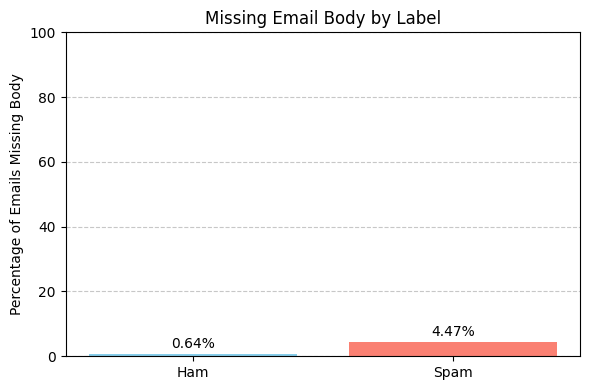

In [24]:
missing_body = df['email_body'] == '<NO_BODY>'

ham_total = df[df['label'] == 0].shape[0]
spam_total = df[df['label'] == 1].shape[0]
ham_missing = df[missing_body & (df['label'] == 0)].shape[0]
spam_missing = df[missing_body & (df['label'] == 1)].shape[0]

ham_missing_pct = round((ham_missing / ham_total) * 100, 2)
spam_missing_pct = round((spam_missing / spam_total) * 100, 2)

plt.figure(figsize=(6, 4))
bars = plt.bar(['Ham', 'Spam'], [ham_missing_pct, spam_missing_pct], color=['skyblue', 'salmon'])

for bar, pct in zip(bars, [ham_missing_pct, spam_missing_pct]):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1, f'{pct}%', ha='center', va='bottom', fontsize=10)

plt.ylabel('Percentage of Emails Missing Body')
plt.title('Missing Email Body by Label')
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [25]:
df["subject_length"] = df["subject"].fillna("").apply(len)

avg_lengths = df.groupby("label")["subject_length"].mean().round(2)

print(f"Average ham subject length: {avg_lengths[0]} characters")
print(f"Average spam subject length: {avg_lengths[1]} characters")


Average ham subject length: 31.17 characters
Average spam subject length: 52.69 characters


In [26]:
def clean_top_words(series, top_n=5):
    text = " ".join(series.dropna().astype(str).str.lower())
    words = re.findall(r'\b[a-z]{3,}\b', text) 
    filtered = [word for word in words if word not in ENGLISH_STOP_WORDS]
    return Counter(filtered).most_common(top_n)

top_spam_words = clean_top_words(df[df["label"] == 1]["subject"])
top_ham_words = clean_top_words(df[df["label"] == 0]["subject"])

print("Top 5 Spam Subject Words:")
for word, count in top_spam_words:
    print(f"{word}: {count}")

print("\nTop 5 Ham Subject Words:")
for word, count in top_ham_words:
    print(f"{word}: {count}")


Top 5 Spam Subject Words:
software: 776
online: 625
new: 547
money: 427
cheap: 377

Top 5 Ham Subject Words:
enron: 1134
hourahead: 774
date: 641
hpl: 636
start: 603


In [27]:
df.iloc[33715]["subject"]

"\\nhtml\\nbody\\nb\\npwhy not take a look at h _ g _ h / b / p\\nplose weight in 3 weeks ! / p\\npachieve many benefits , including : br\\nbr\\nwatch wrinkles disappearbr\\nbody fat loss - 82 % improvementbr\\ngrow new hairbr\\n/ p\\npdo this all with : br\\nbr\\nno strenuous exercisebr\\nno dietingbr\\n/ p\\na href = http : / / www . khe . chnzdc . com / at /\\nphttp : / / www . zou . chnzdc . com / at / / a / p\\npbr\\nbr\\na href = http : / / www . mhx . ebrbf 5 . com / 1 . phpi want to say\\nadios / a / p\\npbr\\nbr\\nbayda midst nomograph revelation apricot comptroller actinide path cadillac bedtime butene crypt extroversion intersect docile paraphernalia crackpot tift eighteen pancreatic aster bob constitutive west exponentiate uranium promenade bark charity enos mollie rosalie complimentary designate cbs remainder slip ludlow dramaturgy length erastus piquant blissful dimple injunction kayo ingestion coverage astronautic lexical organometallic lifetime arcsine aden / p\\n/ body

In [28]:
def fuzzy_url_detect(text):
    if pd.isna(text):
        return False
    cleaned = re.sub(r"[ \n\t]+", "", text.lower())
    return bool(re.search(r"http[s]?[:]?[/]{2}", cleaned))

df["subject_has_url"] = df["subject"].apply(fuzzy_url_detect)
df["body_has_url"] = df["email_body"].apply(fuzzy_url_detect)

messages_with_urls = df[df["subject_has_url"] | df["body_has_url"]]

print(f"Messages with URLs: {messages_with_urls.shape[0]}")

Messages with URLs: 5554


In [29]:
df.shape

(33716, 8)

In [30]:
body_url_df = df[df["body_has_url"] == True]

total = body_url_df.shape[0]
spam_count = body_url_df[body_url_df["label"] == 1].shape[0]
ham_count = body_url_df[body_url_df["label"] == 0].shape[0]

print(f"Total emails with URL in body: {total}")
print(f"Spam emails: {spam_count}")
print(f"Ham emails: {ham_count}")

Total emails with URL in body: 5477
Spam emails: 4740
Ham emails: 737


In [31]:
def clean_body_words(text):
    if pd.isna(text):
        return text
    cleaned = re.sub(
        r"https?:\/\/\S+\.(com|fr|net|org|info|biz|co|uk|de|ru|cn|in|us|eu|tv|me|io|xyz|top|site|online|tech|store|app|live|news|email|click|link|space|website|club|today|world|digital|center|company|services|solutions|network|media|group|systems|agency|capital|finance|marketing|support|cloud|shop|blog|web|page|works|tools|zone|plus|press|fun|cool|expert|global|life|love|money|name|social|team|tips|trade|video|vip|wiki|win|work|pro|rocks|review|sale|school|show|studio|style|watch|webcam)\b\S*",
        "<LINK>",
        text,
        flags=re.IGNORECASE
    )

    cleaned = re.sub(r"\b\S+\.(com|fr|net|org|info|biz|co|uk|de|ru|cn|in|us|eu|tv|me|io|xyz)\b", "<LINK>", cleaned, flags=re.IGNORECASE)
    cleaned = re.sub(r"\b(http|https|www|com)\b", "<LINK>", cleaned, flags=re.IGNORECASE)

    return cleaned.strip()
    
df["email_body"] = df["email_body"].apply(clean_body_words)

top_spam_words = clean_top_words(df[df["label"] == 1]["email_body"])
top_ham_words = clean_top_words(df[df["label"] == 0]["email_body"])

print("Top 5 Spam body Words:")
for word, count in top_spam_words[:5]:
    print(f"{word}: {count}")

print("\nTop 5 Ham body Words:")
for word, count in top_ham_words[:5]:
    print(f"{word}: {count}")


Top 5 Spam body Words:
link: 23347
company: 10572
information: 6942
statements: 6460
email: 6432

Top 5 Ham body Words:
enron: 18976
link: 6182
new: 4965
company: 4686
energy: 4440


In [32]:
link_count = df["email_body"].str.contains("<LINK>").sum()
print(f"Total emails containing <LINK>: {link_count}")

Total emails containing <LINK>: 8929


In [33]:
df["link_word_count"] = df["email_body"].str.count(r"\blink\b")
df["link_token_count"] = df["email_body"].str.count(r"<LINK>")
print("Total 'link' word count:", df["link_word_count"].sum())
print("Total '<LINK>' token count:", df["link_token_count"].sum())

Total 'link' word count: 1707
Total '<LINK>' token count: 27822


Text(0.5, 1.0, 'Distribution of <LINK> tokens in Spam vs Ham')

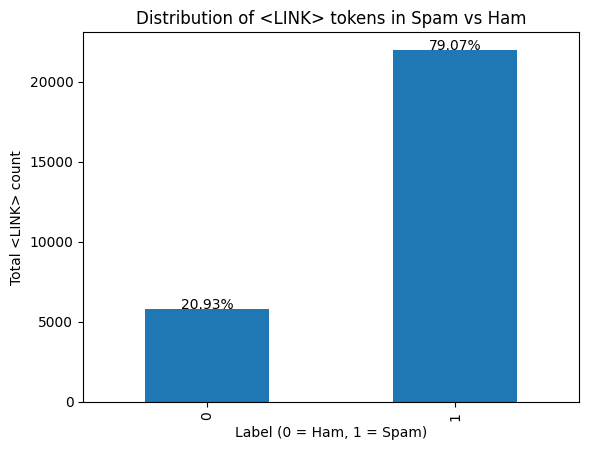

In [34]:
link_counts = df.groupby("label")["link_token_count"].sum()

ax = link_counts.plot(kind="bar")
total = link_counts.sum()
for i, val in enumerate(link_counts):
    pct = (val / total) * 100 if total > 0 else 0
    ax.text(i, val + 0.5, f"{pct:.2f}%", ha="center")

ax.set_xlabel("Label (0 = Ham, 1 = Spam)")
ax.set_ylabel("Total <LINK> count")
ax.set_title("Distribution of <LINK> tokens in Spam vs Ham")

Text(0.5, 1.0, 'Distribution of emails with URL in Spam vs Ham')

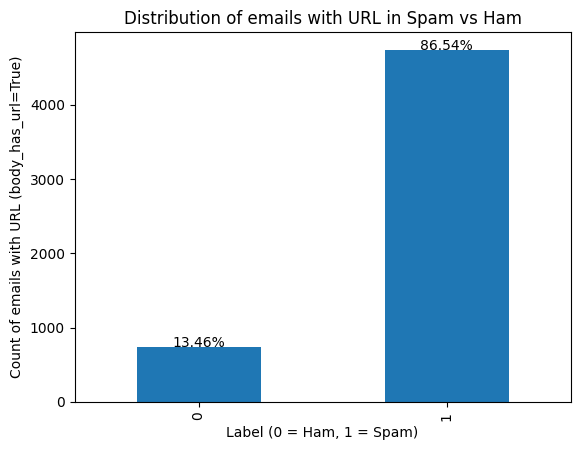

In [35]:
url_counts = df.groupby("label")["body_has_url"].sum()

ax = url_counts.plot(kind="bar")

total = url_counts.sum()
for i, val in enumerate(url_counts):
    pct = (val / total) * 100 if total > 0 else 0
    ax.text(i, val + 0.5, f"{pct:.2f}%", ha="center")

ax.set_xlabel("Label (0 = Ham, 1 = Spam)")
ax.set_ylabel("Count of emails with URL (body_has_url=True)")
ax.set_title("Distribution of emails with URL in Spam vs Ham")

Text(0.5, 1.0, 'Average number of URLs per email body')

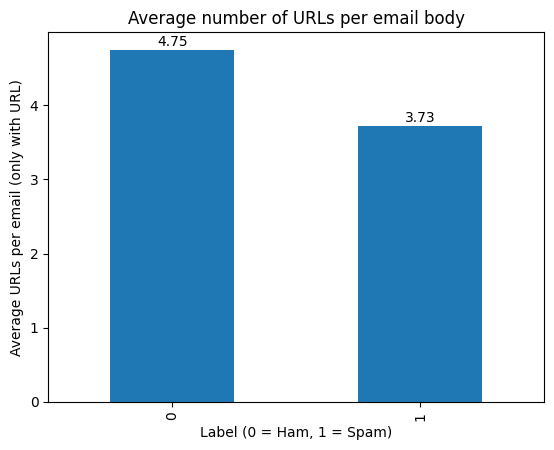

In [36]:
avg_urls_cond = (
    df[df["body_has_url"] == True]
    .groupby("label")["link_token_count"]
    .mean()
)

ax = avg_urls_cond.plot(kind="bar")

for i, val in enumerate(avg_urls_cond):
    ax.text(i, val + 0.05, f"{val:.2f}", ha="center")

ax.set_xlabel("Label (0 = Ham, 1 = Spam)")
ax.set_ylabel("Average URLs per email (only with URL)")
ax.set_title("Average number of URLs per email body")

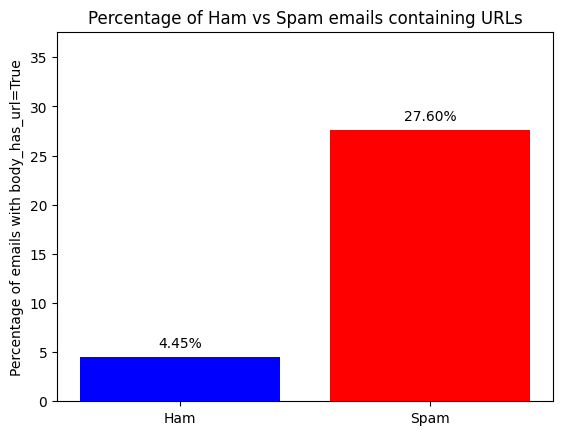

In [38]:
spam_total = df[df["label"] == 1].shape[0]
spam_with_url = df[(df["label"] == 1) & (df["body_has_url"] == True)].shape[0]
spam_pct = (spam_with_url / spam_total) * 100

ham_total = df[df["label"] == 0].shape[0]
ham_with_url = df[(df["label"] == 0) & (df["body_has_url"] == True)].shape[0]
ham_pct = (ham_with_url / ham_total) * 100

percentages = [ham_pct, spam_pct]
labels = ["Ham", "Spam"]

fig, ax = plt.subplots()
bars = ax.bar(labels, percentages, color=["blue", "red"])

for bar, pct in zip(bars, percentages):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 1, f"{pct:.2f}%", ha="center")

ax.set_ylabel("Percentage of emails with body_has_url=True")
ax.set_title("Percentage of Ham vs Spam emails containing URLs")
plt.ylim(0, max(percentages) + 10)
plt.show()
